In [342]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd
import os
import ndjson
import chess.pgn
import seaborn as sns
import matplotlib.pyplot as plt
import math

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [343]:
df = pd.read_json("data/raw/stockfish_150.ndjson", lines = True)
df = df.fillna(0)

print(len(df))
df = df[df['white_cpl'].apply(lambda x: len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: len(x) > 0)]
print(len(df))

df["ECO"] = df["ECO"].astype('category')
df["Opening"] = df["Opening"].astype('category')
df["result"] = df["result"].astype('category')

df["mean_elos"] = df[['white_elo', 'black_elo']].mean(axis=1)
df["diff_elos"] = df['white_elo'] - df['black_elo']

df['white_mean'] = df['white_cpl'].apply(np.mean)
df['white_std'] = df['white_cpl'].apply(np.std)
df['white_min'] = df['white_cpl'].apply(np.min)
df['white_max'] = df['white_cpl'].apply(np.max)

df['black_mean'] = df['black_cpl'].apply(np.mean)
df['black_std'] = df['black_cpl'].apply(np.std)
df['black_min'] = df['black_cpl'].apply(np.min)
df['black_max'] = df['black_cpl'].apply(np.max)

df['stockfish_mean'] = df['stockfish_eval'].apply(np.mean)
df['stockfish_std'] = df['stockfish_eval'].apply(np.std)
df['stockfish_min'] = df['stockfish_eval'].apply(np.min)
df['stockfish_max'] = df['stockfish_eval'].apply(np.max)

1000
997


In [347]:
features = ["white_mean", "white_std", "white_min", "white_max", "black_mean", "black_std", "black_min", "black_max", "stockfish_mean", "stockfish_std", "stockfish_min", "stockfish_max", "mean_elos"]
X_features = ["white_mean", "white_std", "white_min", "white_max", "black_mean", "black_std", "black_min", "black_max", "stockfish_mean", "stockfish_std", "stockfish_min", "stockfish_max"]
dep_var = "mean_elos"


In [348]:
df = df[features]

In [349]:
df_train = df[:800]
df_test = df[800:]

In [350]:
y_test = df_test["mean_elos"]
X_test = df_test.drop(["mean_elos"], axis = 1)

In [351]:
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(df_train, procs=procs, cont_names=X_features, 
                                 y_names="mean_elos", valid_pct=0.2)

In [352]:
dls.show_batch()

,white_mean,white_std,white_min,white_max,black_mean,black_std,black_min,black_max,stockfish_mean,stockfish_std,stockfish_min,stockfish_max,mean_elos
0,14.750000,31.422951,-32.000000,133.999998,15.321428,15.709536,-5.000000,63.999997,-20.116666,56.749769,-207.000000,72.000002,1790.5
1,53.482757,86.773038,-102.000001,270.000003,51.103447,92.295006,-51.000000,346.999995,-11.362068,84.558221,-244.000002,225.999999,1976.0
2,22.600001,35.086994,-15.000001,179.000000,34.676472,44.850548,-43.000000,184.000000,146.507244,135.123734,-37.999996,497.999994,1950.5
3,20.743589,68.277985,-37.000000,395.000006,9.589743,25.279685,-41.000000,79.000002,-238.999994,166.446503,-554.999998,29.999989,2587.5
4,30.840000,53.861065,-17.000000,266.000001,10.240000,18.976365,-17.999999,59.000002,-238.260008,222.093198,-521.999997,75.999998,2196.5
5,9.098039,28.725376,-70.000001,122.000000,11.240000,21.631978,-23.000000,89.999999,103.316833,132.174271,-14.000002,504.999999,2467.5
6,7.866667,22.132530,-13.000000,81.000001,5.733333,14.950884,-17.000001,37.999994,60.966666,23.049923,26.000003,101.999997,2504.0
7,14.826087,20.002504,-9.999999,89.999998,17.066668,31.765391,-40.000000,125.999998,166.318681,155.122344,-9.000001,496.000003,2319.5
8,20.369566,32.349556,-32.000000,126.999999,13.260870,26.131304,-36.000000,98.000002,-67.434781,185.909654,-480.000004,175.000001,2590.5
9,10.760000,16.000700,-9.000000,50.000002,10.840000,13.171728,-6.000001,41.999995,-29.760001,23.104600,-67.999999,14.000002,2016.5


In [354]:
y = dls.train.y
y.min(),y.max()

(1549.5, 2779.0)

In [355]:
learn = tabular_learner(dls,layers=[64,32], y_range=(1500, 2900),n_out=1, loss_func=F.mse_loss, metrics=rmse)

In [356]:
# Train the model using one-cycle learning
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,_rmse,time
0,137322.484375,73866.578125,271.784058,00:00
1,113224.960938,60363.718750,245.690292,00:00
2,92098.453125,52552.312500,229.242920,00:00
3,78762.554688,53975.988281,232.327347,00:00
4,68091.992188,55520.675781,235.628265,00:00
5,62912.632812,55210.335938,234.968796,00:00
6,58213.898438,54580.898438,233.625549,00:00
7,54769.187500,55242.914062,235.038086,00:00
8,52182.453125,55098.468750,234.730637,00:00
9,49541.597656,55266.070312,235.087357,00:00


SuggestedLRs(valley=0.0030199517495930195)

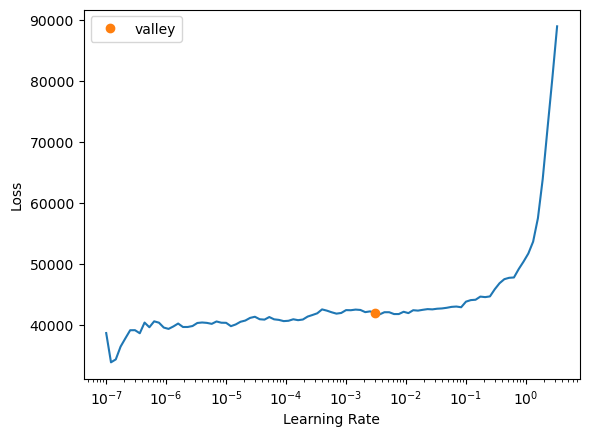

In [357]:

learn.lr_find()

In [358]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,42364.269531,64745.574219,254.451508,00:00
1,42175.832031,70177.125000,264.909637,00:00
2,40528.796875,59820.226562,244.581741,00:00
3,40638.421875,61318.257812,247.625229,00:00
4,40801.582031,59828.542969,244.598740,00:00


In [359]:
abs_error_mean = np.absolute(error).mean()
upper_bound_preds = y + abs_error_mean
lower_bound_preds = y - abs_error_mean

print(f'The Mean Absolute Error is {abs_error_mean}')

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

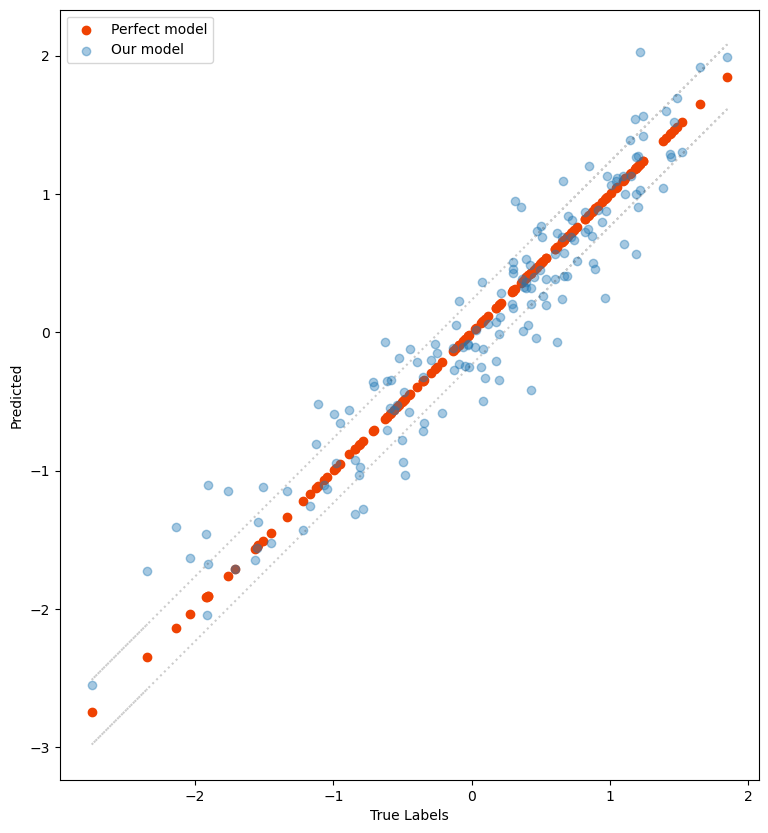

In [232]:
plt.figure(figsize=(12,10))
plt.axes(aspect='equal')
plt.scatter(y.detach().numpy(),y.detach().numpy(), color='#EF4202',label='Perfect model')
plt.scatter(y.detach().numpy(), preds, alpha=0.4,label='Our model')
plt.plot(y.detach().numpy(), upper_bound_preds.detach().numpy(), alpha=0.2,color='black',linestyle='dotted')
plt.plot(y.detach().numpy(), lower_bound_preds.detach().numpy(), alpha=0.2,color='black',linestyle='dotted')
plt.xlabel('True Labels')
plt.ylabel('Predicted')
plt.legend()
plt.show()

In [233]:
preds, y = learn.get_preds()

In [234]:
# Make predictions on test data
dl = learn.dls.test_dl(df_test)
preds, _ = learn.get_preds(dl=dl)

mean, std = df['mean_elos'].mean(), df['mean_elos'].std()

# Inverse normalization manually
original_preds = preds * std + mean

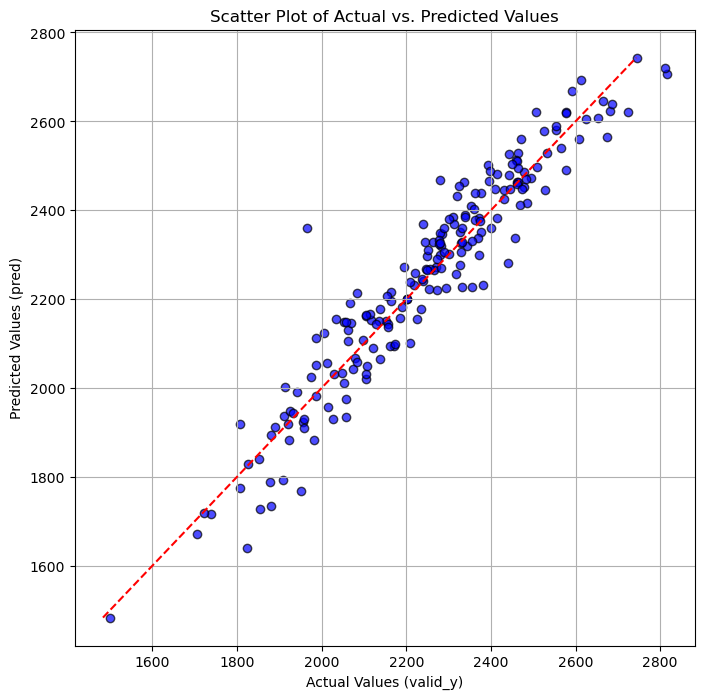

In [235]:
import matplotlib.pyplot as plt

# Assuming valid_y and pred are your actual and predicted values
# valid_y = [your actual values]
# pred = [your predicted values]

plt.figure(figsize=(8, 8))
plt.scatter(original_preds, y_test, edgecolor='k', color='b', alpha=0.7)

# Adding a diagonal line to indicate perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

# Adding titles and labels
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.xlabel('Actual Values (valid_y)')
plt.ylabel('Predicted Values (pred)')

# Adding a grid for better readability
plt.grid(True)

# Show the plot
plt.show()